# Sentiment Analysis for Hotel Reviews

## Overview
applying sentiment analysis to hotel reviews using **Mutual Information** and **Vader Sentiment Analyzer**.

 **Vader sentiment analyzer, Mutual Information and Point-wise Mutual Information** are used to discover the relation between those metrics and ground-truth rating scores.

In [1]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/maria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

In [7]:
hotelDf = pd.read_csv('Data2.txt', sep=";;", header=None,error_bad_lines=False)
hotelDf.columns = ["review_id", "overall_rating", "title_of_the_review", "text_of_the_review", "username", "location_of_the_user", 
                "hotel_id", "date_stayed", "date_of_the_review"]
hotelDf['text_of_the_review'] = hotelDf.apply(lambda row: '' if row['text_of_the_review'] is None else row['text_of_the_review'] , axis=1)

# hotelDfassiging groundtruth to our dataset 
# the groundtruth is categorical variable ('positive', 'negative'). 
# If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

hotelDf['groundTruth'] = hotelDf.apply(lambda row: 'positive' if float(row['overall_rating']) > 3 else 'negative' , axis=1)

hotelDf.to_csv('dataset.csv', sep=';')

/home/maria/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
Skipping line 50647: Expected 9 fields in line 50647, saw 11. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 71068: Expected 9 fields in line 71068, saw 10. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 73612: Expected 9 fields in line 73612, saw 11. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 104136: Expected 9 fields in line 104136, saw 10. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 122095:

In [3]:
hotelDf = pd.read_csv('dataset.csv', sep=";")

/home/maria/anaconda3/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
hotelDf = hotelDf.sample(frac = 0.1, replace = False, random_state=42)

In [5]:
hotelDf.head()

,Unnamed: 0,review_id,overall_rating,title_of_the_review,text_of_the_review,username,location_of_the_user,hotel_id,date_stayed,date_of_the_review,groundTruth
659101,659101,122194164,5.0,“Really Nice People”,I am writing this review as I am sitting in th...,Debbie039,New Jersey,268533,December 2011,"December 28, 2011",positive
709136,709136,57627158,5.0,“A nice getaway and you don't even have to lea...,This is a wonderful hotel with a very attentiv...,landofenchantment,"Alamogordo, NM",98805,February 2010,"March 3, 2010",positive
527089,527089,116062495,4.0,"“kleines, ruhiges Hotel in netter Gegend”","Wir hatten Raum 325, der zur Seitenstraße gele...",WaWa2010,Düsseldorf,109345,March 2011,"July 31, 2011",positive
310666,310666,123565612,1.0,"“Two star for the hotel, one (zero, if possibl...",This is rather an old review for our stay in J...,lovebossa,"East Lansing, MI",114595,June 2011,"January 24, 2012",negative
351825,351825,116592452,5.0,“Loved the style and uniqueness of this hotel”,Stayed at the Standard for a few nights on bus...,drohecker,"Vancouver, Washington",249696,June 2011,"August 11, 2011",positive


In [18]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [19]:

vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['text_of_the_review']):
    
    if review is None:
        review=""
    scores = sid.polarity_scores(review)

    vaderScores.append(scores['compound'])
#     if (rownum % 5000 == 0):
#             print("processed %d reviews" % (rownum+1))
print("completed")

completed


In [20]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,Unnamed: 0,review_id,overall_rating,title_of_the_review,text_of_the_review,username,location_of_the_user,hotel_id,date_stayed,date_of_the_review,groundTruth,vaderScore
659101,659101,122194164,5.0,“Really Nice People”,I am writing this review as I am sitting in th...,Debbie039,New Jersey,268533,December 2011,"December 28, 2011",positive,0.6141
709136,709136,57627158,5.0,“A nice getaway and you don't even have to lea...,This is a wonderful hotel with a very attentiv...,landofenchantment,"Alamogordo, NM",98805,February 2010,"March 3, 2010",positive,0.6591
527089,527089,116062495,4.0,"“kleines, ruhiges Hotel in netter Gegend”","Wir hatten Raum 325, der zur Seitenstraße gele...",WaWa2010,Düsseldorf,109345,March 2011,"July 31, 2011",positive,-0.9818
310666,310666,123565612,1.0,"“Two star for the hotel, one (zero, if possibl...",This is rather an old review for our stay in J...,lovebossa,"East Lansing, MI",114595,June 2011,"January 24, 2012",negative,0.9715
351825,351825,116592452,5.0,“Loved the style and uniqueness of this hotel”,Stayed at the Standard for a few nights on bus...,drohecker,"Vancouver, Washington",249696,June 2011,"August 11, 2011",positive,0.9920


In [21]:
hotelDf.head(5)

,Unnamed: 0,review_id,overall_rating,title_of_the_review,text_of_the_review,username,location_of_the_user,hotel_id,date_stayed,date_of_the_review,groundTruth,vaderScore
659101,659101,122194164,5.0,“Really Nice People”,I am writing this review as I am sitting in th...,Debbie039,New Jersey,268533,December 2011,"December 28, 2011",positive,0.6141
709136,709136,57627158,5.0,“A nice getaway and you don't even have to lea...,This is a wonderful hotel with a very attentiv...,landofenchantment,"Alamogordo, NM",98805,February 2010,"March 3, 2010",positive,0.6591
527089,527089,116062495,4.0,"“kleines, ruhiges Hotel in netter Gegend”","Wir hatten Raum 325, der zur Seitenstraße gele...",WaWa2010,Düsseldorf,109345,March 2011,"July 31, 2011",positive,-0.9818
310666,310666,123565612,1.0,"“Two star for the hotel, one (zero, if possibl...",This is rather an old review for our stay in J...,lovebossa,"East Lansing, MI",114595,June 2011,"January 24, 2012",negative,0.9715
351825,351825,116592452,5.0,“Loved the style and uniqueness of this hotel”,Stayed at the Standard for a few nights on bus...,drohecker,"Vancouver, Washington",249696,June 2011,"August 11, 2011",positive,0.9920


## Can we learn something about the true ratings from Vader scores?
In other words, can we build infer true review ratings by using vader score? and why even would we be intereted in that?

Usually, we have many other options for the regression problem. *Linear Regression*, *Decision Tree* and etc.

But using Vader analyzer is **simple and fast**. We can use it as an initial tool before building a heavy machine learning model to figure out the trend in the data.

#### Top 5 reviews hotel by *ratings*

In [22]:
ratingByHotel = hotelDf.groupby(['hotel_id']).mean()['overall_rating'].reset_index()
vaderByHotel = hotelDf.groupby(['hotel_id']).mean()['vaderScore'].reset_index()

In [23]:
ratingByHotel = ratingByHotel.sort_values('overall_rating', ascending=False)
ratingByHotel.head(20)

,hotel_id,overall_rating
3463,;93569,5.0
1737,258634,5.0
1270,223027,5.0
1213,217717,5.0
1188,217199,5.0
1187,217193,5.0
1175,2151620,5.0
1170,2145772,5.0
1149,2027969,5.0
1141,1963064,5.0


#### Top 5 reviews hotel by *vader score*

In [24]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(20)

,hotel_id,vaderScore
1380,223708,0.998900
543,115612,0.998600
775,121999,0.998200
1930,3405788,0.997600
2037,574244,0.996000
23,100559,0.995900
2031,570515,0.994700
904,1382102,0.993900
1683,249576,0.993900
555,1158744,0.993500


### The two lists are very similar!
Vader scores are highly correlated with the true rating scores.

## Which words were most sentiment-bearing in the reviews?
#### To explore this question, we will calculate the following 3 factors.
1. Word Frequency
2. Mutual Information
3. Pointwise Mutual Information (PMI)

### 1. Word Frequency
Can word frequency in review data tell us how the customers felt about the hotels?


Let's get the most frequently observed words from the *positive reviews* and *negative reviews*, respectively, to see the difference, if any.

In [25]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    k is for max features value
    Extract the most frequently occurred words in countvector
    the ngram range of (1,1) is unigram
    (1,2) meana unigram and bigram
    (2,2) means only bigrams 
    
    max_features parameter in count vectorizer int or None, default=None
    If not None, build a vocabulary that only consider the top max_features (((((ordered by term frequency across the corpus.)))))

    This parameter is ignored if vocabulary is not None.
    '''

    my_stop_words = ENGLISH_STOP_WORDS
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=k)
        

        
    countvector = vectorizer.fit_transform(df['text_of_the_review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [26]:
topkTotal = get_topk_ngram(hotelDf, k=100)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=100)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

The most frequently occured top 10 words in positive reviews
       Word   Count
0     hotel  109757
1      room   75514
2     great   45321
3      stay   38652
4     staff   38545
5  location   28143
6      nice   27917
7     rooms   26916
8      good   26916
9     clean   25353

The most frequently occured top 10 words in negative reviews
     Word  Count
0    room  44918
1   hotel  44917
2    stay  14301
3   rooms  12608
4   night  12261
5    good  10746
6   staff  10485
7    just   9565
8    desk   9146
9  stayed   8793

The most frequently occured top 10 bigrams in positive reviews
               Word  Count
0          new york   6740
1      times square   5954
2    staff friendly   5884
3  walking distance   5476
4    great location   4731
5  friendly helpful   4322
6        room clean   3740
7   recommend hotel   3381
8   definitely stay   3189
9       hotel great   3130

The most frequently occured top 10 bigrams in negative reviews
               Word  Count
0          new yor

### Uh.. almost same?
It seems like the term frequency doesn't tell us anything about the text. We can observe that there is no difference between the top-k word list for both positive reviews and negative reviews.

If we think about it, this result seems obvious. If a customer was really satistied with the staff in the hotel, they would mention the word, 'staff', in their review. Even if a customer didn't like the staff working in the hotel, they also would mention the word, 'staff', in their review (with some bad words).

### 2. Mutual Information

**Mutual information tells you how much you learn about X from knowing the value of Y (on average over the choice of Y).** 


Since we found the word frequency is not a good indicator for the sentiment analysis, we will examine *mutual information*  for an alternative metric.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [8]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [ ]:
# max feature was 500 i had to ake it 100 because of RAM issues

In [9]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=100)
countvector = vectorizer.fit_transform(hotelDf['text_of_the_review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(100)]}
                              , index = vectorizer.get_feature_names())



In [11]:
# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=100)
countvector = vectorizer.fit_transform(hotelDf['text_of_the_review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(100)]},
                    index = vectorizer.get_feature_names())

In [10]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
great,0.021238
room,0.014240
helpful,0.010228
comfortable,0.009535
staff,0.009438
excellent,0.009372
friendly,0.009314
night,0.008957
wonderful,0.008631
desk,0.008145


In [12]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
definitely stay,0.007820
highly recommend,0.006378
friendly helpful,0.003727
walking distance,0.003193
staff friendly,0.002306
great hotel,0.002255
times square,0.002018
enjoyed stay,0.002015
clean comfortable,0.001939
great place,0.001883


### What does it mean?
If we observe words having high Mutual Information scores in a review, we would learn a lot about the sentiment of review, (positive or negative).

###  3. Pointwise Mutual Information

Similar to MI, PMI is measuring for single event where MI is the average of all possible event.

The events P(x,y) = P(0,1) means the event of the review is negative but the specific word is existing in that review

#### Let's see how Pointwise Mutual Information calculated. The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence.
#### To study more about Pointwise Mutual Information, see [Wikipedia](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ff54cfce726857db855d4dd0a9dee2c6a5e7be99)

In [6]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=100):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['text_of_the_review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [7]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')


In [8]:
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

### Let's see what PMI values tell us about the reviews

In [9]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
wonderful,0.092638
excellent,0.082713
definitely,0.077036
helpful,0.069001
restaurants,0.065742
quiet,0.065660
comfortable,0.062230
friendly,0.058853
suite,0.056537
recommend,0.053145


In [10]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
definitely stay,0.122378
highly recommend,0.121792
great stay,0.110282
enjoyed stay,0.101417
location perfect,0.097511
great hotel,0.095214
great place,0.091987
great service,0.089629
staff great,0.084544
helpful friendly,0.083019


In [11]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
old,0.186201
don,0.173011
better,0.152130
people,0.133461
did,0.132020
door,0.129459
didn,0.128238
shower,0.127285
got,0.110409
need,0.107237


In [12]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
got room,0.259273
star hotel,0.237313
holiday inn,0.214530
room room,0.196829
parking lot,0.182978
room small,0.180265
booked hotel,0.160072
customer service,0.141623
good location,0.123736
10 minutes,0.120026


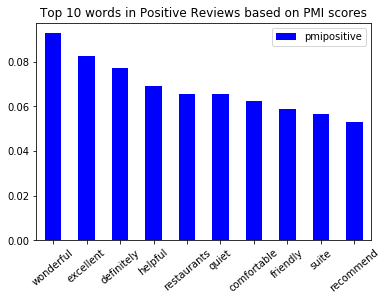

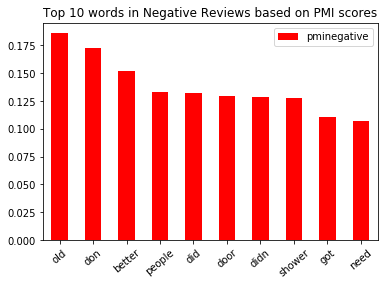

In [13]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

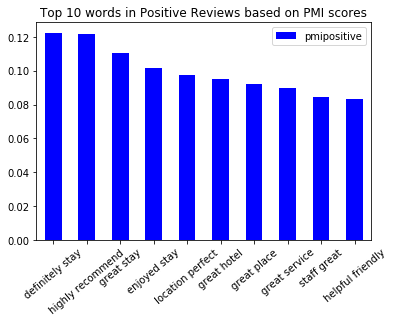

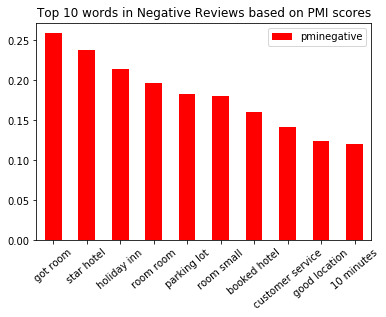

In [14]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

### Pointwise Mutual Information seems like a good metric to summarize the reviews in n-gram tokens!
### By reading the n-gram tokens with high PMI scores for target variable, we can get a sense how much the reviewer did or didn't like the hotels. 

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

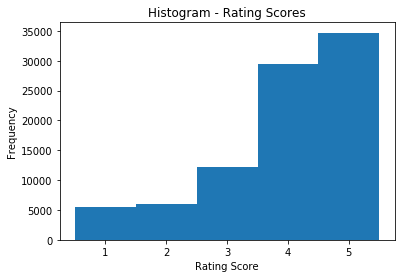

In [15]:
plt.xlabel('Rating Score')
hotelDf['overall_rating'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

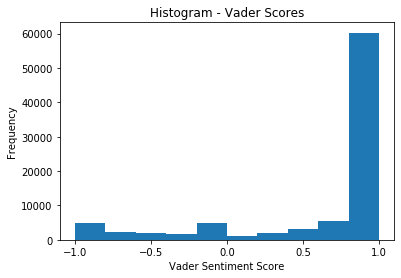

In [27]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

/home/maria/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/maria/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


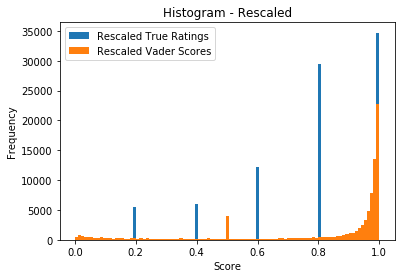

In [28]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['overall_rating'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

## Scatterplots

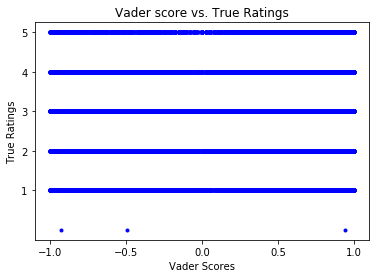

In [45]:
y = hotelDf['overall_rating'].values
x = hotelDf['vaderScore'].values
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()